In [ ]:
import pandas as pd

# Load data from the Excel file
file_path = '/content/ECG Datasets.xlsx'
df = pd.read_excel(file_path)

# Display the original DataFrame
#print("Original DataFrame:")
#print(df['A'])

# Perform min-max normalization on column 'A'
min_value = df['A'].min()
max_value = df['A'].max()

df['A'] = (df['A'] - min_value) / (max_value - min_value)

# Create new columns for the next three time steps
df['B'] = df['A'].shift(-1)
df['C'] = df['A'].shift(-2)
df['D'] = df['A'].shift(-3)
df['E'] = df['A'].shift(-4)


# Drop the rows with missing values (for the last three time steps)
df = df.dropna()

# Convert the DataFrame to a NumPy array
numpy_array = df.values

print(numpy_array)

[[0.92902542 0.93855932 0.94597458 0.94915254 0.95444915]
 [0.93855932 0.94597458 0.94915254 0.95444915 0.95550847]
 [0.94597458 0.94915254 0.95444915 0.95550847 0.96080508]
 ...
 [0.77754237 0.77542373 0.77118644 0.77118644 0.77542373]
 [0.77542373 0.77118644 0.77118644 0.77542373 0.77330508]
 [0.77118644 0.77118644 0.77542373 0.77330508 0.77860169]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sigmoid and tanh activation functions and their derivatives
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(output):
    return output * (1 - output)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(output):
    return 1 - output ** 2

# Mean Squared Error loss and its derivative
def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mse_loss_derivative(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)

class LSTMCell:
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.Wf = np.random.randn(hidden_size, hidden_size + input_size)
        self.Wi = np.random.randn(hidden_size, hidden_size + input_size)
        self.Wo = np.random.randn(hidden_size, hidden_size + input_size)
        self.Wc = np.random.randn(hidden_size, hidden_size + input_size)
        self.bf = np.zeros(hidden_size)
        self.bi = np.zeros(hidden_size)
        self.bo = np.zeros(hidden_size)
        self.bc = np.zeros(hidden_size)
        self.Wy = np.random.randn(1, hidden_size)  # Output weight matrix to map hidden state to output size
        self.by = np.zeros(1)  # Bias for the output layer

    def forward(self, x, h_prev, c_prev):
        self.x, self.h_prev, self.c_prev = x, h_prev, c_prev
        self.combined = np.hstack((h_prev, x))
        self.f = sigmoid(np.dot(self.Wf, self.combined) + self.bf)
        self.i = sigmoid(np.dot(self.Wi, self.combined) + self.bi)
        self.o = sigmoid(np.dot(self.Wo, self.combined) + self.bo)
        self.c_hat = tanh(np.dot(self.Wc, self.combined) + self.bc)
        self.c = self.f * c_prev + self.i * self.c_hat
        self.h = self.o * tanh(self.c)
        self.y_pred = np.dot(self.Wy, self.h) + self.by  # Output layer
        return self.y_pred, self.h, self.c

    def backward(self, dL_dy, dh_next, dc_next, learning_rate):
        dy_dh = self.Wy
        dh = np.dot(dy_dh.T, dL_dy) + dh_next
        dc = dh * self.o * tanh_derivative(tanh(self.c)) + dc_next

        df = dc * self.c_prev * sigmoid_derivative(self.f)
        di = dc * self.c_hat * sigmoid_derivative(self.i)
        do = dh * tanh(self.c) * sigmoid_derivative(self.o)
        dc_hat = dc * self.i * tanh_derivative(self.c_hat)

        dWf = np.dot(df.reshape(-1, 1), self.combined.reshape(1, -1))
        dWi = np.dot(di.reshape(-1, 1), self.combined.reshape(1, -1))
        dWo = np.dot(do.reshape(-1, 1), self.combined.reshape(1, -1))
        dWc = np.dot(dc_hat.reshape(-1, 1), self.combined.reshape(1, -1))

        dbf = df
        dbi = di
        dbo = do
        dbc = dc_hat

        dWy = np.dot(dL_dy, self.h.reshape(1, -1))
        dby = dL_dy

        # Update weights and biases
        self.Wf -= learning_rate * dWf
        self.Wi -= learning_rate * dWi
        self.Wo -= learning_rate * dWo
        self.Wc -= learning_rate * dWc
        self.bf -= learning_rate * dbf
        self.bi -= learning_rate * dbi
        self.bo -= learning_rate * dbo
        self.bc -= learning_rate * dbc
        self.Wy -= learning_rate * dWy
        self.by -= learning_rate * dby.reshape(-1)

        dcombined = np.dot(self.Wf.T, df) + np.dot(self.Wi.T, di) + np.dot(self.Wo.T, do) + np.dot(self.Wc.T, dc_hat)
        dh_prev = dcombined[:self.hidden_size]
        dc_prev = dc * self.f

        return dh_prev, dc_prev

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


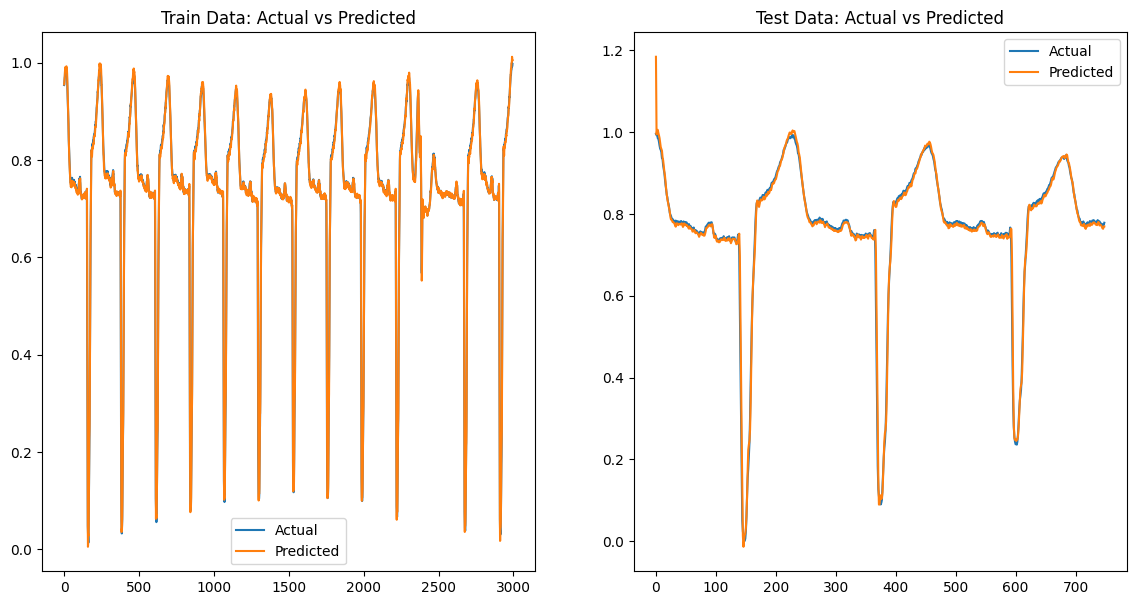

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Continued setup: Initialize LSTM cell, prepare data, and define training/testing parameters
input_size = 1
hidden_size = 4
timesteps = 1000
learning_rate = 0.001
sequence_length = 4

# Initialize LSTM cell with extended functionalities
lstm_cell = LSTMCell(input_size, hidden_size)

# Split data into input X and output Y
X = numpy_array[:, :-1]  # All rows, all but last column
Y = numpy_array[:, -1]   # All rows, only last column

# Assuming a simple train-test split
split_index = int(0.8 * len(X))
X_train_seq, Y_train_seq = X[:split_index], Y[:split_index]
X_test_seq, Y_test_seq = X[split_index:], Y[split_index:]

# print(Y_test_seq)

# Lists to store predictions
train_predictions = []
test_predictions = []

h, c = np.zeros(hidden_size), np.zeros(hidden_size)  # Reset states at the start of each epoch
# Training loop
for epoch in range(200):
    print(epoch)
    train_predictions = []
    test_predictions = []
    for t in range(len(X_train_seq)):
        x_seq, y_true = X_train_seq[t], Y_train_seq[t]
        for x in x_seq:
            y_pred, h, c = lstm_cell.forward(x, h, c)
        train_predictions.append(y_pred.item())
        dL_dy = mse_loss_derivative(y_true, y_pred)
        dh_next = np.zeros_like(h)
        dc_next = np.zeros_like(c)
        for x in reversed(x_seq):
            dh_prev, dc_prev = lstm_cell.backward(dL_dy, dh_next, dc_next, learning_rate)
            dh_next, dc_next = dh_prev, dc_prev

# Testing loop (No backpropagation)
h, c = np.zeros(hidden_size), np.zeros(hidden_size)  # Reset states for testing
for t in range(len(X_test_seq)):
    x_seq, y_true = X_test_seq[t], Y_test_seq[t]
    for x in x_seq:
        y_pred, h, c = lstm_cell.forward(x, h, c)
    test_predictions.append(y_pred.item())

# Plotting train predictions vs actual data
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(Y_train_seq)), Y_train_seq, label="Actual")
plt.plot(np.arange(len(train_predictions)), train_predictions, label="Predicted", linestyle='-')
plt.title("Train Data: Actual vs Predicted")
plt.legend()

# Plotting test predictions vs actual data
plt.subplot(1, 2, 2)
plt.plot(np.arange(len(Y_test_seq)), Y_test_seq, label="Actual")
plt.plot(np.arange(len(test_predictions)), test_predictions, label="Predicted", linestyle='-')
plt.title("Test Data: Actual vs Predicted")
plt.legend()

plt.show()


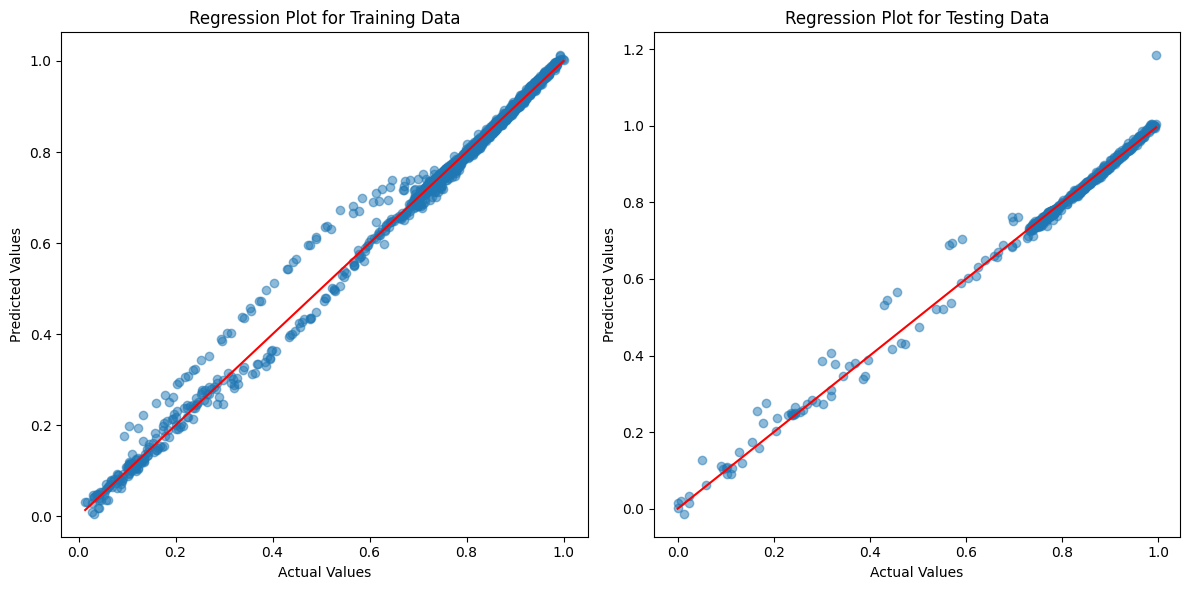

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'train_predictions' and 'test_predictions' contain the predictions from the LSTM model,
# and 'Y_train_seq' and 'Y_test_seq' contain the actual values.

# Plot regression for training data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(Y_train_seq, train_predictions, alpha=0.5)
plt.title("Regression Plot for Training Data")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.plot([min(Y_train_seq), max(Y_train_seq)], [min(Y_train_seq), max(Y_train_seq)], color='red') # Line showing perfect prediction

# Plot regression for testing data
plt.subplot(1, 2, 2)
plt.scatter(Y_test_seq, test_predictions, alpha=0.5)
plt.title("Regression Plot for Testing Data")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.plot([min(Y_test_seq), max(Y_test_seq)], [min(Y_test_seq), max(Y_test_seq)], color='red') # Line showing perfect prediction

plt.tight_layout()
plt.show()
